# Data Extraction Notebook
The phenotype data for the funnel cross project was extracted from individual plate images by running the cells of code in this notebook. First, necessary python packages are imported and helper functions are defined. Then a list is constructed constituting the relevant image files to be processed and folders are set up to recieve the quantitave image features. Finally,the images are processed, exporting the data for patch areas, raw integral densities, and local binary pattern profiles to a .csv file. Throughout this process, images for which the default cropping method failed are added to a folder. These images were revisited with alternative crop locations manually provided in lines 12-14 of cell 3.

### 1. Import packages and define segmentation functions.

In [23]:
# -- Load Packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import ndimage as ndi
from scipy.signal import find_peaks
from PIL import Image
from pathlib import Path
from shutil import copy2

import glob
import os
import sys
sys.path.append('./') # disable for mac

import skimage
from skimage.transform import hough_circle
from skimage.feature import peak_local_max
from skimage.draw import circle
from skimage.exposure import histogram
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label
from skimage.morphology import closing, square

%matplotlib inline

# -- Define Helper Functions 
def ListFiles(folder):
    '''
    input: 
        folder: the name of a folder, which must be in the current working directory
    output: 
     - files: a list of the names of the files in folder
    '''
    path = Path(os.getcwd() + '\\' + folder)
    files = os.listdir(path)
    return files

def DisplayTiles(tile_list):
    '''
    Display rectangular regions of interest in 8 x 12 array matching the position of each patch on the plate.
    input: tile_list
    output: none
    '''
    fig, axs = plt.subplots(8, 12,figsize=(12,8))
    count = 0
    for j in range(0,8):
        for jj in range(0,12):
            axs[j,jj].imshow(tile_list[count])
            axs[j,jj].axis('off')
            count = count + 1
    plt.show();

def SegmentTiles(tiles, min_radii=28, max_radii=35, Display=False):
    '''
    input:
        - tiles: list of grayscale tiles, each roughly centered on a single patch to be segmented. 
        optional
        - min_radii:the smallest possible patch size, or the radius of the pin used to lay down yeast cells.
        - max_radii: overestimate of the largest size that a patch would grow to while still remaining very faint
        - Display: True or False, indicating whether to display the segmented tiles that result
    
    output:
        - colony_masks: list of arrays with entries 1 corresponding to in-colony pixels and entries 0 corresponding
                        to background pixels
        - clean_tiles: list of segmented tiles, with background pixels set to 0 and in-colony pixels set to grayscale val
        - thresholds:  list of the threshold used to segment each tile. The threshold was determined using Otsu's method
        - background: the mean background value across all tiles.

    '''
    
    if Display:
        DisplayTiles(tiles)
    
    colony_masks = []
    clean_tiles = []
    thresholds = []
    background_list = [np.median(t[0:20,0:200]) for t in tiles]
    background = np.mean(background_list)
        
    count = 0

    for t in tiles:
            
        # apply threshold
        thresh = threshold_otsu(t)
        bw = closing(t > thresh, square(3))
        bw = ndi.binary_fill_holes(bw)

        # label image regions
        label_image = label(bw)

        # Detect circle (corresponding to initial pin if colony is faint)
        edges = 1*(t>np.mean(t)+.02)
        hough_radii = np.arange(min_radii,max_radii, 0.5)
        hough_res = hough_circle(edges, hough_radii)
        centers = []
        accums = []
        radii = []
        for radius, h in zip(hough_radii, hough_res):
            # For each radius, extract one circle
            peaks = peak_local_max(h, num_peaks=1)
            centers.extend(peaks)
            accums.extend(h[peaks[:, 0],peaks[:,1]])
            radii.extend([radius])

        # Pick the most prominent circle for mask
        idx = np.argmax(accums)
        center_x, center_y = centers[idx]
        radius = radii[idx]
        cx, cy = circle(center_x, center_y, radius)
        colony_mask = np.zeros_like(t)
        try:
            colony_mask[cx,cy] = 1
        except:
            pass
        colony_mask = colony_mask>0

        # Combine with thresholding result if the colony is not completely null
        if thresh> background + 0.04: #0.35 #.42
            label_objects, nb_labels = ndi.label(1*((label_image+colony_mask)>0))

            # Select largest object
            sizes = np.bincount(label_objects.ravel())
            mask_sizes = sizes > 2000
            mask_sizes[0] = 0
            colony_mask_temp = mask_sizes[label_objects]
            # remove artifacts connected to image border
            colony_mask = clear_border(colony_mask_temp) 
            # check that colony wasn't touching image border
            if abs(np.sum(1*colony_mask_temp) - np.sum(1*colony_mask)) > 500 and np.var(t>.002):
                print('Object touching edge in tile:', count)
                print(thresh)


        # Change to Blank if tile is empty
        if np.mean(t[50:-50,50:-50]*colony_mask[50:-50,50:-50])<.035 or np.max(accums)<=0.35:
            colony_mask = np.zeros_like(t)>0

        colony_masks.append(colony_mask)
        clean_tiles.append(t*colony_mask)
        thresholds.append(thresh)
        count = count + 1
    if Display:
        DisplayTiles(clean_tiles)
    return colony_masks, clean_tiles, thresholds, background

def SizeFeatures(clean_tile_list, colony_mask_list, tile_list,background):
    '''
    input:
        - clean_tile_list: list of segmented tiles
        - colony_mask_list: list of colony masks used to produce clean_tile_list
        - tile_list: list of raw tiles in grayscale
        - background: average background value across all tiles in tile_list
    output:
        - areas: list of the area of each patch
        - pixel_sums: list of the sum of all the pixels contained in each patch
        - intdens: list of the sum of all the pixels contained in each patch, normalized by subtracting background*area 
        - perimeters: list of the perimeter of each patch
        
    '''
    areas = []
    pixel_sums = []
    perimeters = []

    for j in range(0,len(clean_tile_list)):
        mask = colony_mask_list[j]
        clean_tile = clean_tile_list[j]
        colony_area = np.sum(mask)
        areas.append(colony_area)
        pixel_sums.append(np.sum(clean_tile))  
        perimeters.append(skimage.measure.perimeter(mask))

    intdens = [pixel_sum -background*area for pixel_sum,area in zip(pixel_sums,areas)]
                                   
    return areas, pixel_sums, intdens, perimeters

def TextureFeatures(intdens,colony_masks, clean_tiles):
    '''
    input: 
        - intden: list of integral densities for each patch
        - colony_masks: list of masks segmenting each patch from the background
        - clean_tiles: list of segmented tiles
    output:
        - LBP_list: list of tiles with colony pixels labeled according to which LBP they fall under
        - score: n x 10 array containing the fraction of colony pixels falling 
                into each of the 10 LBP categories. For this project n = 96 plate positions.
    '''
    LBP_list = ([mask*skimage.feature.local_binary_pattern(tile, 8, 10, method='uniform') 
                 for (mask,tile) in zip(colony_masks,clean_tiles)])
    scores = np.zeros((96,10)) 
    for j in range(0, 96):
        if areas[j]>0:
            LBP_t = LBP_list[j]
            hist, hist_centers = histogram(LBP_t[colony_masks[j]])
            temp = hist[hist>0]/areas[j]
            scores[j,:] = temp
        else:
            scores[j,:] = np.array([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])
        
    return LBP_list, scores

### 2. Set up folders to house results and make a list of images to be processed.

In [8]:
# -- Set up file paths

ImageFolderPath = r'C:\Users\Katherine\Desktop'
ImageFolderFolder = r'C:\Users\Katherine\Desktop\Images'
key = 'Images'
ExtractedValuePath = os.path.join(ImageFolderFolder,'Extracted_Values_'+key)

if not os.path.exists(os.path.join(ImageFolderFolder,'Cropping Error')):
    os.makedirs(os.path.join(ImageFolderFolder,'Cropping Error'))
    
if not os.path.exists(os.path.join(r'C:\Users\Katherine\Desktop\Images','Other Error')):
    os.makedirs(os.path.join(r'C:\Users\Katherine\Desktop\Images','Other Error'))

if not os.path.exists(ExtractedValuePath):
    os.makedirs(ExtractedValuePath)
    
# -- Make list of the plate position names
positions = ([x+y for x in ['A','B','C','D','E','F','G','H'] 
            for y in ['1','2','3','4','5','6','7','8','9','10','11','12']])

# -- Make List of image files
os.chdir(ImageFolderPath)
file_list = ListFiles(key)
im_list = [x  for x in file_list if "jpg" in x] # limit attention to jpg files
os.chdir(ImageFolderFolder)

### 3. Loop through the images, extracting size and texture features and saving the output to a csv file.

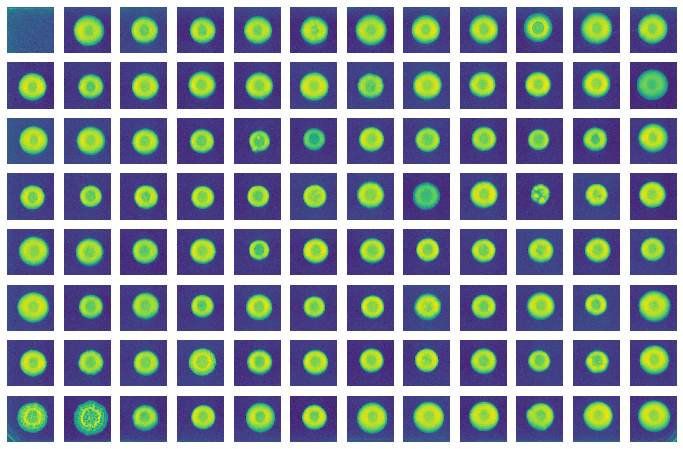

YCR71P01_CF_72h_12-02-11.jpg


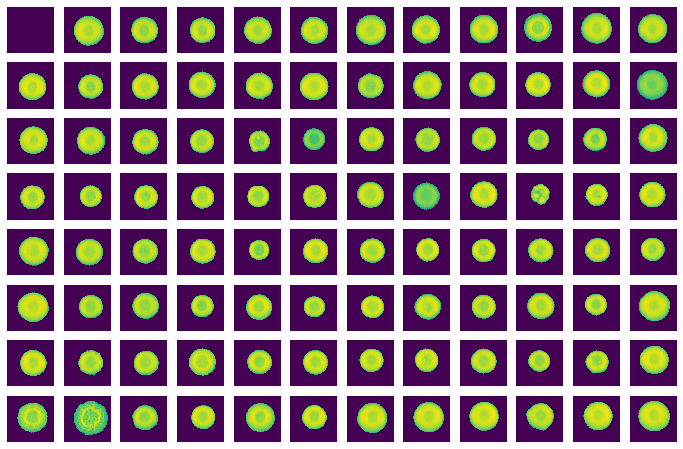

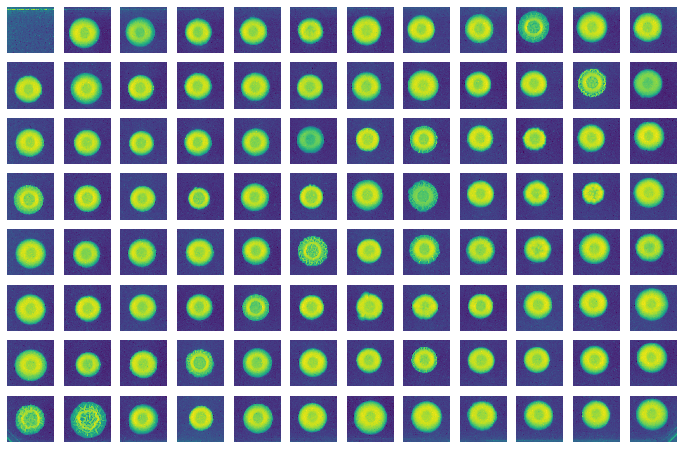

YCR71P01_CHX_72h_12-01-56.jpg


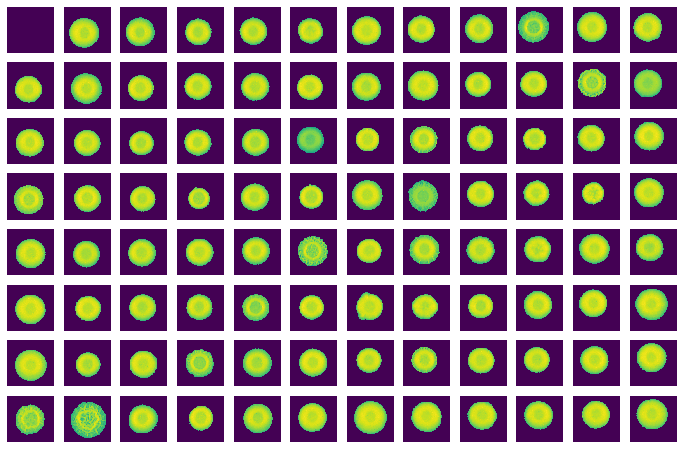

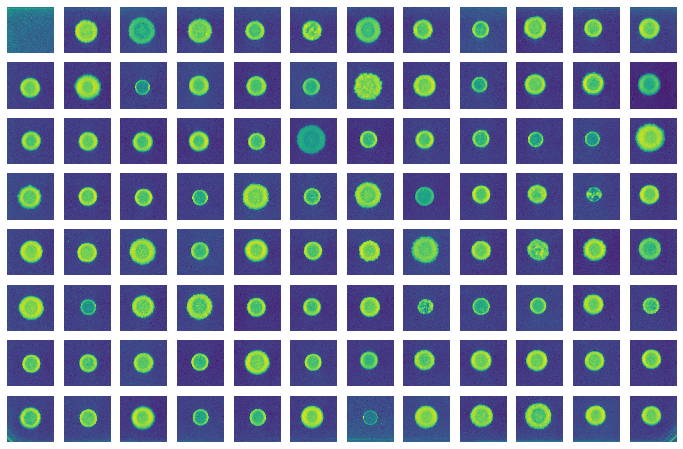

YCR71P01_HU_72h_12-01-15.jpg


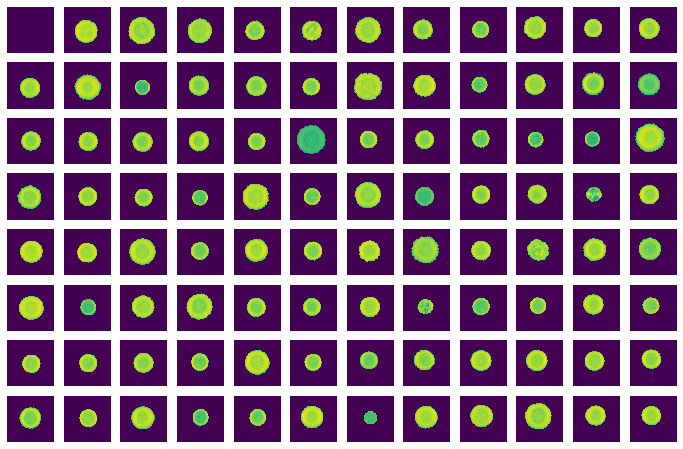

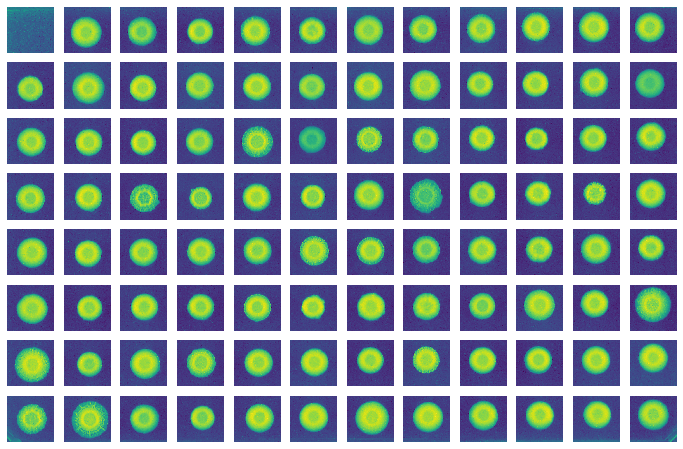

YCR71P01_RAPA_72h_12-01-01.jpg


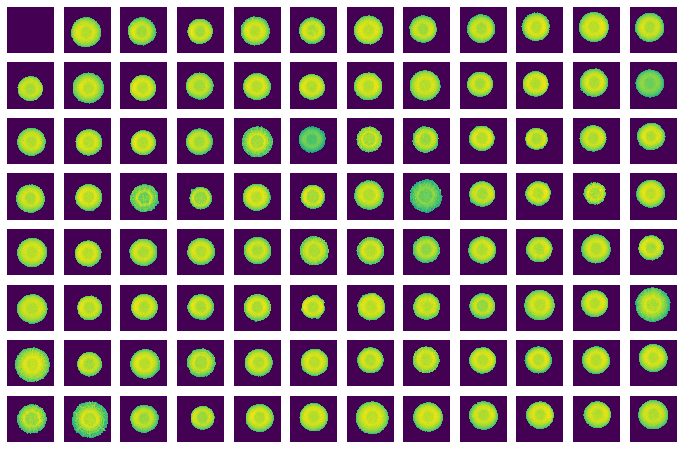

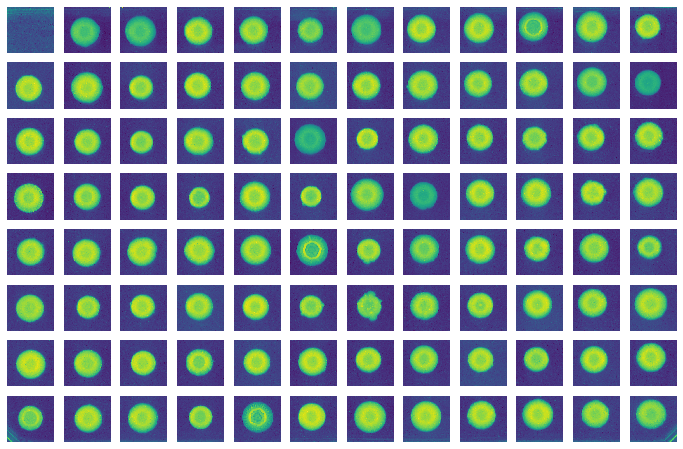

YCR71P01_SORB_72h_12-00-48.jpg


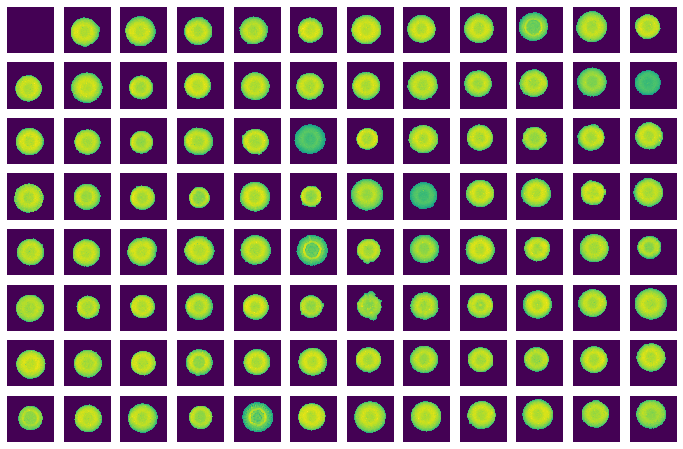

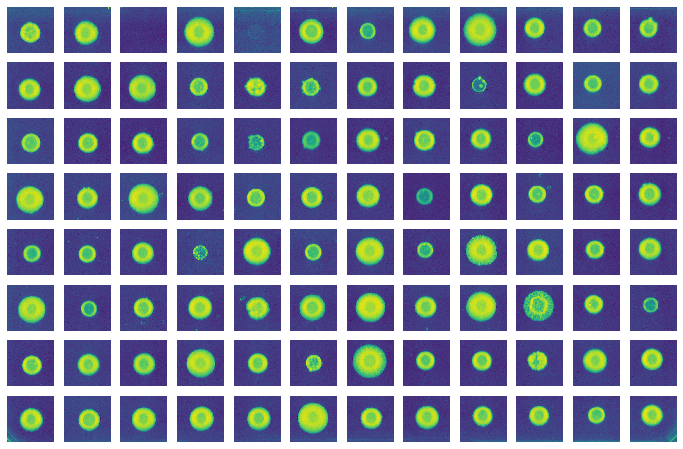

YCR71P03_CdCl2_72h_12-10-06.jpg


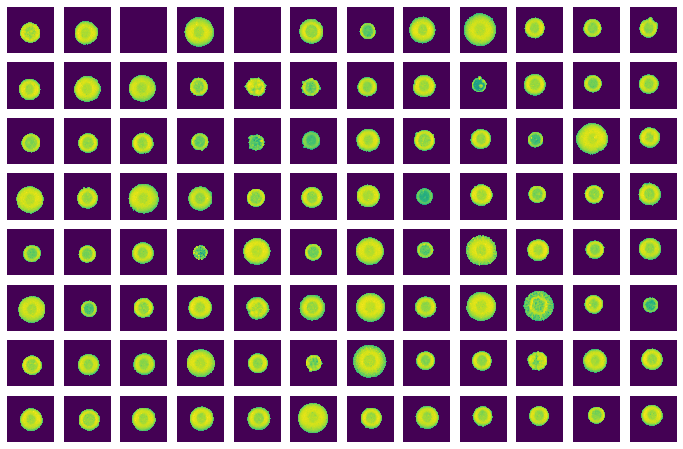

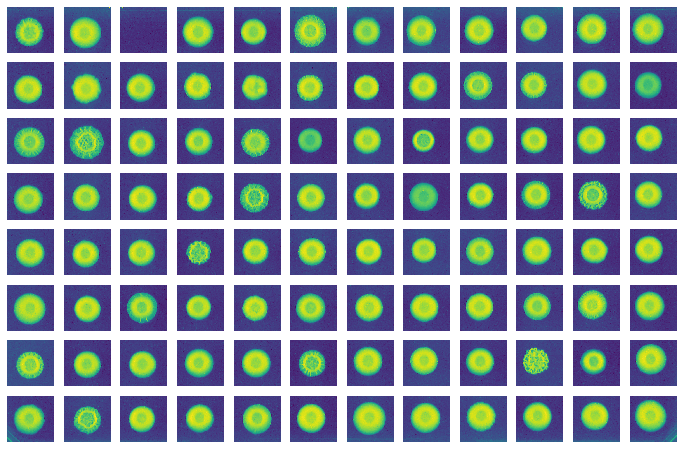

YCR71P03_CHX_72h_12-09-18.jpg


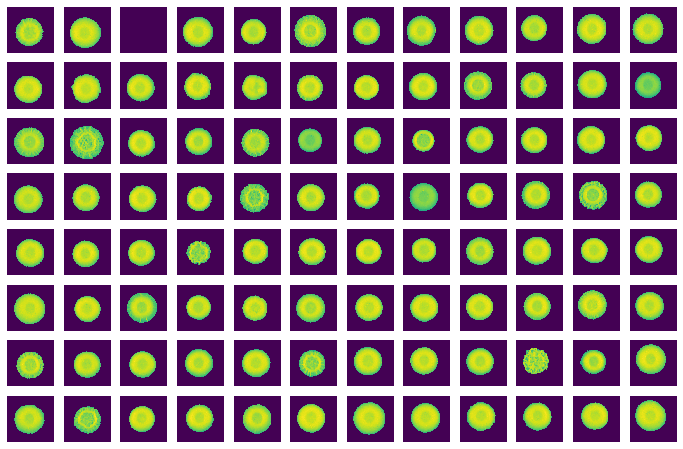

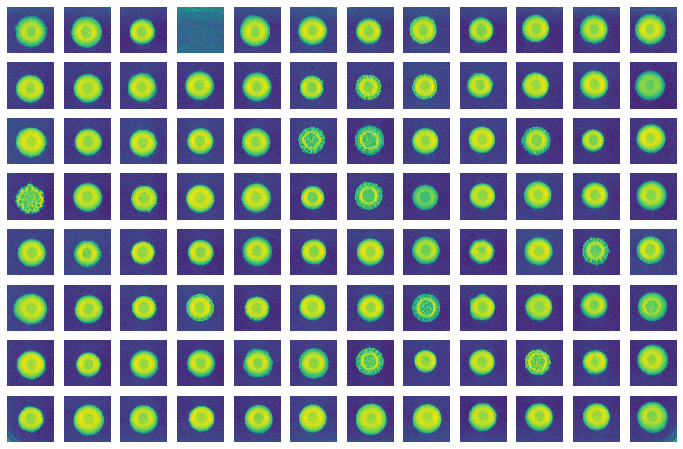

YCR73P04_YPD_72h_12-12-09.jpg


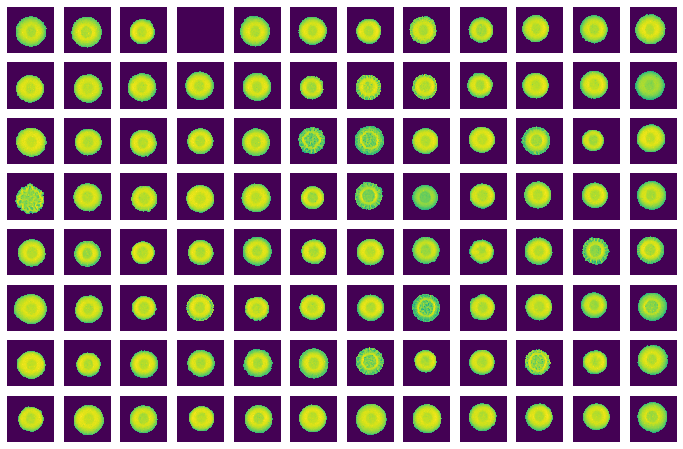

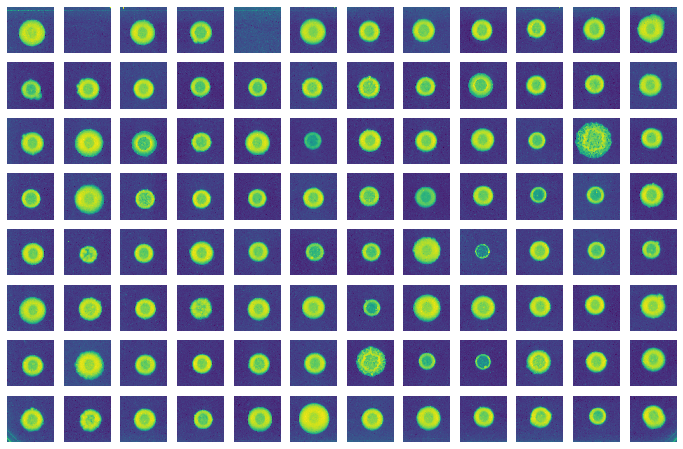

YCR73P05_CdCl2_72h_12-16-51.jpg


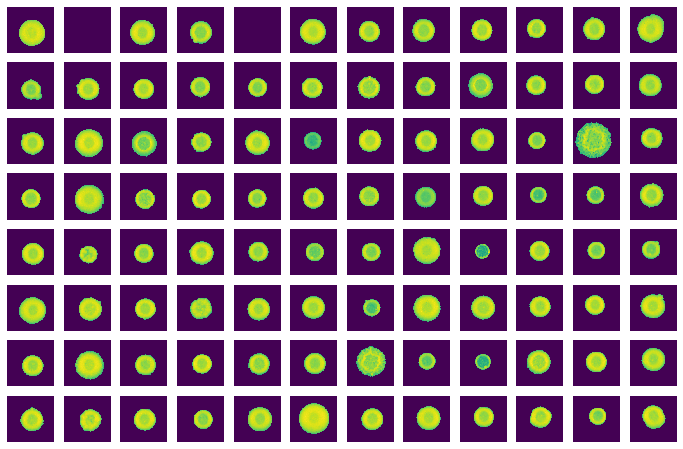

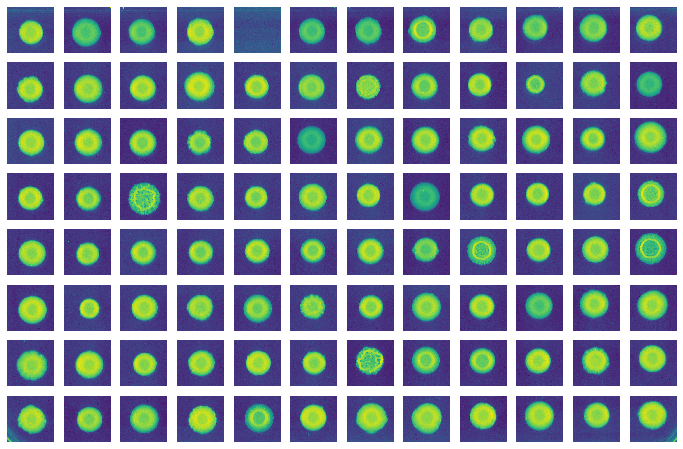

YCR73P05_SORB_72h_12-15-07.jpg


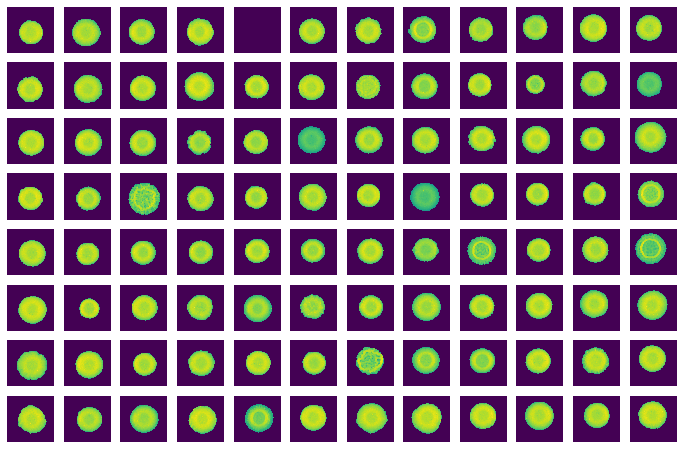

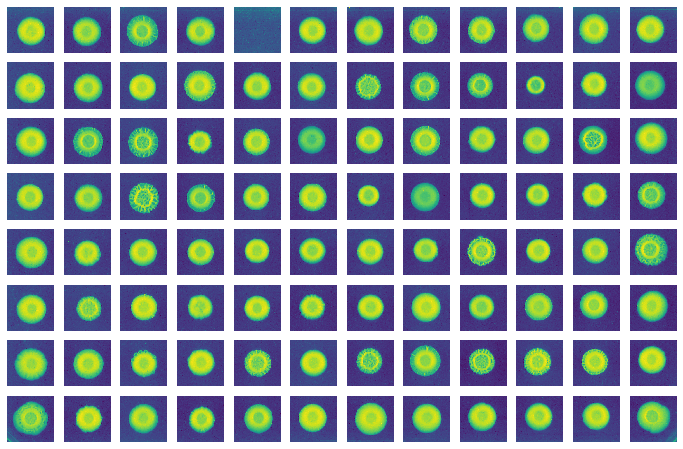

YCR73P05_YPD_72h_12-14-49.jpg


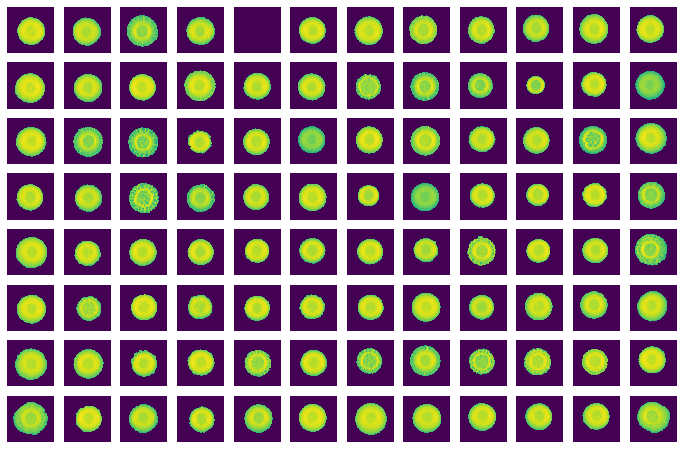

In [25]:
# Loop through plate images and process each one

Display = True # Display can be set to True or False. If True, the cropping and segmetation results 
               # will be displayed to the screen. If False, only the name of the file processed will be displayed.

for i in range(0,len(im_list)):
    # Load Plate
    cell_plate = skimage.io.imread(im_list[i])
    filename = im_list[i].split('.')[0]+'.csv'
    cell_plate = ndi.rotate(cell_plate,180) # This rotation is necessary because skimage.io.imread() rotates the image
    
    # Consistent crop location used because images were taken with plate in almost identical position
    cell_plate_cropped_gray = skimage.color.rgb2gray(cell_plate[500:2220,455:3215])
    crop_locs_x = np.arange(0,2220-500,214)
    crop_locs_y = np.arange(0,3215-455,215)


    # Check that crop locations are not passing through a patch
    x = np.sum(cell_plate_cropped_gray,axis = 1)
    sig1 = abs((np.mean(x[crop_locs_x[1:-1]]) - np.mean(x[crop_locs_x[1:-1]-20]))/20)<1
    sig2 = abs((np.mean(x[crop_locs_x[1:-1]+20])-np.mean(x[crop_locs_x[1:-1]]))/20)<1
    sig3 = abs((np.mean(x[crop_locs_x[1:-1]-20])-np.mean(x[crop_locs_x[1:-1]+20]))/40)<1

    y = np.sum(cell_plate_cropped_gray,axis = 0)    
    sig4 = abs((np.mean(y[crop_locs_y[1:-1]]) - np.mean(y[crop_locs_y[1:-1]-20]))/20)<1
    sig5 = abs((np.mean(y[crop_locs_y[1:-1]+20])-np.mean(y[crop_locs_y[1:-1]]))/20)<1
    sig6 = abs((np.mean(y[crop_locs_y[1:-1]-20])-np.mean(y[crop_locs_y[1:-1]+20]))/40)<1

    if sig1 and sig2 and sig3 and sig4 and sig5 and sig6:
        tiles = []
        for j in range(0,len(crop_locs_x)-1):
            row = cell_plate_cropped_gray[np.int(crop_locs_x[j]):np.int(crop_locs_x[j+1]):1,:]
            for jj in range(0,len(crop_locs_y)-1):
                cropped_section = row[:,np.int(crop_locs_y[jj]):np.int(crop_locs_y[jj+1]):1]
                tiles.append(cropped_section)
        if  Display:
            DisplayTiles(tiles)
        try:
            print(im_list[i])
            colony_masks, clean_tiles, thresholds, background = SegmentTiles(tiles)    
            if Display:
                DisplayTiles(clean_tiles)
            areas, pixel_sums, intdens, perimeters = SizeFeatures(clean_tiles, colony_masks, tiles, background) 
            LBP_filtered, LBP_scores = TextureFeatures(intdens,colony_masks,tiles)
            
            data = ({'Position':  positions, 'Area': areas, 'IntDen': pixel_sums, 
                    'LBP1': LBP_scores[:,0],'LBP2': LBP_scores[:,1],'LBP3': LBP_scores[:,2], 
                    'LBP4': LBP_scores[:,3],'LBP5': LBP_scores[:,4],'LBP6': LBP_scores[:,5], 
                    'LBP7': LBP_scores[:,6], 'LBP8': LBP_scores[:,7],'LBP9': LBP_scores[:,8],
                    'LBP10': LBP_scores[:,9]})
            df = (pd.DataFrame(data, columns = ['Position','Area','IntDen',
                                                'LBP1','LBP2','LBP3', 'LBP4', 'LBP5', 
                                                'LBP6','LBP7', 'LBP8', 'LBP9','LBP10']))
            (df.to_csv(os.path.join(ExtractedValuePath,filename), index=False))
        except:
            print('Other Error', i)
            (copy2(os.path.join(ImageFolderFolder,im_list[i]),os.path.join(ImageFolderFolder,'Other Error')))
            pass
    else: 
        print('Miscropped image:', im_list[i])
        (copy2(os.path.join(ImageFolderFolder,im_list[i]),os.path.join(ImageFolderFolder,'Cropping Error')))